# OLG リスクとライフサイクル

## ライブラリのインポート

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from typing import Callable
from dataclasses import dataclass
import matplotlib.pyplot as plt

## settings.py

In [3]:
"""
Settingクラスは、オーバーラッピング・ジェネレーションズ（OLG）モデルの基本的なパラメータ設定を管理するクラスです。

主な機能:
- 割引因子、リスク回避度、資本分配率、減耗率、年金の所得代替率など、モデルの主要パラメータを初期化します。
- モデルの期間や労働・引退開始年齢、初期資産、収束判定の閾値も設定できます。
- 効用関数（CRRA型）と限界効用関数をパラメータに応じて定義します。
- 人口分布（mu）と各年齢の労働生産性（theta）を全て1で初期化します。

注意:
- モデルのイテレーションを通じて変化する変数はこのクラスには含めません。
- モデルの構造を変更する場合は、このクラスのパラメータを修正してください。
"""

from typing import Callable
import numpy as np
from numba import njit


class Setting:
    """
    設定クラス（Setting）
    このクラスは、OLG（Overlapping Generations）モデルにおける主要なパラメータを管理します。
    割引因子、リスク回避度、資本分配率、減耗率、年金の所得代替率、モデル期間、労働・引退開始年齢、初期資産、収束判定閾値などを属性として保持します。
    また、CRRA型効用関数および限界効用関数を定義し、人口分布および各年齢の労働生産性を初期化します。
    Attributes:
        beta (float): 割引因子
        gamma (float): 相対的リスク回避度（異時点間の代替弾力性の逆数）
        alpha (float): 資本分配率
        delta (float): 固定資本減耗率
        psi (float): 年金の平均所得代替率
        J (int): モデルの期間（世代数）
        jw (int): 勤労期の初期年齢
        jr (int): 引退期の初期年齢
        a1 (float): 初期資産
        tol (float): 収束判定の閾値
        utility (callable): CRRA型効用関数
        mutility (callable): 限界効用関数
        mu (np.ndarray): 各年齢の人口分布
        theta (np.ndarray): 各年齢の労働生産性
    """

    def __init__(
        self,
        NJ      = 61,        # モデルの期間,20歳から80歳まで生きる
        Njw     = 45,        # 働く期間,20歳から64歳まで働く
        #Njr     = 20,        # 勤労期の初期,20歳から働く 使ってない
        Nl      = 2,         # 生産性のグリッドの数, {high,low}の2種類
        l_dif   = 0.3,       # 生産性の違い
        Na      = 201,       # 今期の資産グリッドの数
        a_max   = 25,        # 資本グリッドの最大値
        a_min   = 0,         # 資本グリッドの最小値
        Naprime = 8001,      # 来季の資産グリッドの数
        alpha   = 0.4,       # 資本分配率
        beta    = 0.98,      # 割引因子
        gamma   = 1,         # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        delta   = 0.08,      # 固定資本減耗率
        psi     = 0.5,       # 年金の平均所得代替率
        K0      = 7.0,       # 初期資産
        tol     = 1e-4,      # 収束判定の閾値
        maxiter = 2000,      # 最大繰り返し回数
        lambdaR = 0.2,       # 資本更新調整係数
        # jw    = 20,        # 勤労期の初期 j work
        # jr    = 45,        # 引退期の初期 j retire
    ):

        # パラメータを設定する
        self.NJ      = NJ
        self.Njw     = Njw
        #self.Njr     = Njr
        self.Nl      = Nl
        self.l_dif   = l_dif
        self.Na      = Na
        self.Naprime = Naprime
        self.a_max   = a_max
        self.a_min   = a_min
        self.alpha   = alpha
        self.beta    = beta
        self.gamma   = gamma
        self.delta   = delta
        self.psi     = psi
        self.K0      = K0
        self.tol     = tol
        self.maxiter = maxiter
        self.lambdaR = lambdaR


        # グリッドの設定
        h_grid            = np.linspace(1, NJ, NJ) # 年齢のグリッド
        l_grid            = np.zeros(Nl)
        l_grid[0]         = 1.0 - l_dif
        l_grid[1]         = 1.0 + l_dif
        a_grid            = np.linspace(a_min, a_max, Na) # 今期資産グリッド
        aprime_grid       = np.linspace(a_min, a_max, Naprime) # 次期資産グリッド

        self.h_grid       = h_grid
        self.l_grid       = l_grid
        self.a_grid       = a_grid
        self.aprime_grid  = aprime_grid

        # 生産性の遷移確率行列Pの用意
        P_HH = 0.8
        P_LL = 0.8

        P = np.array([
            [P_HH   , 1 - P_HH],
            [1-P_LL , P_LL    ]
        ])
        self.P = P

        # CRRA型効用関数と限界効用を定義する
        gamma = self.gamma
        if gamma == 1:
            self.utility = np.log
            self.mutility: Callable[[float], float] = njit(lambda x: 1 / x)
        else:
            self.utility = njit(lambda x: x ** (1 - gamma) / (1 - gamma))
            self.mutility = njit(lambda x: x ** (-gamma))


# numba化された逆補間関数
@njit
def inverse_interp_aprime_point_numba(a_grid, aprime_value):
    """
    1つの aprime_value を、グローバルな a_grid 上で線形補間により逆補間する。
    Parameters:
    - a_grid: 資産グリッド（numpy array）
    - aprime_value: スカラー値（次期資産の1点）
    Returns:
    - aprime_interp: 線形補間により a_grid 上で再構成された aprime_value
    - idx: 左のインデックス
    - idx+1: 右のインデックス
    - weight_L: 左の重み
    - weight_R: 右の重み
    """
    if aprime_value <= a_grid[0]:
        return a_grid[0], 0, 1, 1.0, 0.0
    elif aprime_value >= a_grid[-1]:
        last_idx = len(a_grid) - 1
        return a_grid[-1], last_idx-1, last_idx, 0.0, 1.0
    else:
        # バイナリサーチの代わりに線形サーチ（numbaでより効率的）
        idx = 0
        for i in range(len(a_grid) - 1):
            if a_grid[i] <= aprime_value < a_grid[i + 1]:
                idx = i
                break
        
        a_left = a_grid[idx]
        a_right = a_grid[idx + 1]
        weight_R = (aprime_value - a_left) / (a_right - a_left)
        weight_L = 1.0 - weight_R
        aprime_interp = weight_L * a_left + weight_R * a_right
        return aprime_interp, idx, idx + 1, weight_L, weight_R

# 逆補間のための関数（レガシー版 - 互換性のため残す）
def inverse_interp_aprime_point(hp, aprime_value):
    """
    1つの aprime_value を、グローバルな a_grid 上で線形補間により逆補間する。
    Parameters:
    - aprime_value: スカラー値（次期資産の1点）
    Returns:
    - aprime_interp: 線形補間により a_grid 上で再構成された aprime_value
    """
    return inverse_interp_aprime_point_numba(hp.a_grid, aprime_value)

In [4]:
# numba化された家計最適化問題の後ろ向き計算
@njit
def solve_household_backward_numba(value_fun_box, policy_fun_box, optaprime_index_box,
                                   y_list, a_grid, aprime_grid, P, 
                                   r, beta, gamma, NJ, Nl, Na, Naprime, Njw):
    """
    家計の最適化問題を後ろ向きに解く（numba最適化版）
    """
    # 最終期（年齢NJ-1）の政策関数、価値関数を求める
    for i_l in range(Nl):
        for i_a in range(Na):
            aprime = 0.0
            c = y_list[NJ-1, i_l] + (1 + r) * a_grid[i_a] - aprime
            if gamma == 1:
                value_fun = np.log(c)
            else:
                value_fun = c ** (1 - gamma) / (1 - gamma)
            value_fun_box[NJ-1, i_l, i_a] = value_fun
            optaprime_index_box[NJ-1, i_l, i_a] = 0
            policy_fun_box[NJ-1, i_l, i_a] = aprime

    # 後ろ向きに価値関数・政策関数を計算
    for h in range(NJ-2, -1, -1):  # NJ-2歳から0歳まで繰り返し
        for i_l in range(Nl):  # 今期の生産性i_lについて繰り返し
            y = y_list[h, i_l]
            
            for i_a in range(Na):  # 今期の資産i_aについて繰り返し
                a = a_grid[i_a]
                vtemp = -1e10 * np.ones(Naprime)  # j_a に対する一時的な価値関数
                accmax = Naprime  # サーチされるグリッドの最大値

                for j_a in range(Naprime):  # 次期の資産j_aについて繰り返し
                    aprime = aprime_grid[j_a]
                    
                    # 補間用のインデックスと重みを取得（numba版）
                    _, ac1vec, ac2vec, weight_L, weight_R = inverse_interp_aprime_point_numba(a_grid, aprime)
                    
                    c = y + (1 + r) * a - aprime

                    if c <= 0:
                        accmax = j_a - 1  # 消費が負になったので、それ以降のグリッドは打ち切り
                        break

                    vprime = 0.0
                    for j_l in range(Nl):  # 次期の生産性l_jについて繰り返し
                        prob_l = P[i_l, j_l]
                        V_next = weight_L * value_fun_box[h + 1, j_l, ac1vec] + weight_R * value_fun_box[h + 1, j_l, ac2vec]
                        vprime += prob_l * V_next

                    if gamma == 1:
                        vtemp[j_a] = np.log(c) + beta * vprime
                    else:
                        vtemp[j_a] = c ** (1 - gamma) / (1 - gamma) + beta * vprime

                if accmax >= 0:
                    opt_index = 0
                    max_val = vtemp[0]
                    for idx in range(1, min(accmax + 1, Naprime)):
                        if vtemp[idx] > max_val:
                            max_val = vtemp[idx]
                            opt_index = idx

                    value_fun_box[h, i_l, i_a] = vtemp[opt_index]
                    optaprime_index_box[h, i_l, i_a] = opt_index
                    policy_fun_box[h, i_l, i_a] = aprime_grid[opt_index]

def solve_household_backward(hp, value_fun_box, policy_fun_box, optaprime_index_box, y_list, r):
    """
    家計の最適化問題を後ろ向きに解く（hpインスタンス使用版）
    """
    solve_household_backward_numba(
        value_fun_box, policy_fun_box, optaprime_index_box,
        y_list, hp.a_grid, hp.aprime_grid, hp.P, 
        r, hp.beta, hp.gamma, hp.NJ, hp.Nl, hp.Na, hp.Naprime, hp.Njw
    )

In [5]:
# numba化された分布更新関数
@njit
def update_distribution_numba(mu_dist_box, policy_fun_box, h_dist, a_grid, P, NJ, Nl, Na):
    """
    分布を前向きに更新する（numba最適化版）
    """
    # すべての状態分布mu_distを0に初期化
    mu_dist_box.fill(0.0)
    
    a0_index = 0  # 最小資産のインデックス
    mu_0 = 0.5 * h_dist[0]  # 世代全体を1とする場合の人口比

    mu_dist_box[0, 0, a0_index] = mu_0  # スキル low
    mu_dist_box[0, 1, a0_index] = mu_0  # スキル high

    # 繰り返し、1期ずつ前向きに分布を更新していく
    for h in range(NJ-1):  # 年齢: 0歳〜
        for i_l in range(Nl):  # 今期のスキル
            for i_a in range(Na):  # 今期の資産
                mu = mu_dist_box[h, i_l, i_a]
                #if mu == 0:
                #    continue  # 対象の状態（年齢,状態,資産）に人がいない（=0）の場合スキップ

                # 最適な次期資産の値（実数）を取得
                aprime = policy_fun_box[h, i_l, i_a]

                # 補間用のインデックスと重みを取得
                _, i_opt1, i_opt2, weight_1, weight_2 = inverse_interp_aprime_point_numba(a_grid, aprime)

                for j_l in range(Nl):  # 次期スキル
                    pij = P[i_l, j_l]  # スキル遷移確率

                    # 線形補間で次期分布に割り当て
                    mu_dist_box[h + 1, j_l, i_opt1] += mu * pij * weight_1
                    mu_dist_box[h + 1, j_l, i_opt2] += mu * pij * weight_2

# numba化された資産供給計算関数
@njit
def calculate_asset_supply_numba(mu_dist_box, policy_fun_box, NJ, Nl, Na):
    """
    家計の資産供給を計算する（numba最適化版）
    """
    A_supply = 0.0
    for h in range(NJ):       # 年齢
        for i_l in range(Nl):     # スキル
            for i_a in range(Na): # 今期資産インデックス
                mu = mu_dist_box[h, i_l, i_a]
                if mu == 0:
                    continue
                aprime = policy_fun_box[h, i_l, i_a]  # 次期資産（実数値）
                A_supply += aprime * mu
    return A_supply

def update_distribution(hp, mu_dist_box, policy_fun_box, h_dist):
    """
    分布を前向きに更新する（hpインスタンス使用版）
    """
    update_distribution_numba(mu_dist_box, policy_fun_box, h_dist, hp.a_grid, hp.P, hp.NJ, hp.Nl, hp.Na)

def calculate_asset_supply(hp, mu_dist_box, policy_fun_box):
    """
    家計の資産供給を計算する（hpインスタンス使用版）
    """
    return calculate_asset_supply_numba(mu_dist_box, policy_fun_box, hp.NJ, hp.Nl, hp.Na)

In [6]:
# numba最適化されたメインループ（hpインスタンス使用版）
#hp = Setting(NJ = 10, Njw = 7, Na = 50, Naprime = 1000)
hp = Setting()

# 繰り返しに入る前の準備
# 年齢×スキル×資産,この三次元のようなイメージの箱を作る
value_fun_box   = np.zeros((hp.NJ, hp.Nl, hp.Na))              # 価値関数の箱
optaprime_index_box = np.zeros((hp.NJ, hp.Nl, hp.Na), dtype=int)   # 政策関数の箱（インデックス）
policy_fun_box  = np.zeros((hp.NJ, hp.Nl, hp.Na))              # 政策関数の箱（実数値）

# 2. 労働所得グリッド（初期化）
y_matrix        = np.zeros((hp.NJ, hp.Nl))

# 3. 人口分布（初期化）
mu_dist_box     = np.zeros((hp.NJ, hp.Nl, hp.Na))         # 年齢×スキル×資産 の人口分布

# 4. 年齢別人口分布（死も人口成長もない → 一様分布）
h_dist          = np.ones(hp.NJ) / hp.NJ

# 5. 税率（年金支払いのための均衡税率）
tau = hp.psi * np.sum(h_dist[hp.Njw:]) / np.sum(h_dist[:hp.Njw])

# 6. 総労働供給
L = np.sum(h_dist[:hp.Njw]) # 生産性を入れる？、今回の平均生産性は1だから気持ちは1で割っている,tauchenでやる場合には調整が必要

# 初期化
market_diff = 1.0
errm = 1.0
diff_iteration = 0
K = hp.K0

print("numba最適化されたOLGモデルを実行中...")
import time
start_time = time.time()

while (market_diff > hp.tol or errm > hp.tol) and diff_iteration < hp.maxiter:
    diff_iteration += 1

    # 所与のKからr,w,pを計算する
    r = hp.alpha * (K / L) ** (hp.alpha - 1) - hp.delta
    w = (1 - hp.alpha) * (K / L) ** hp.alpha
    p = hp.psi * w

    # 所得関数（リスト）を設定する
    y_list = y_matrix.copy()  # (年齢, スキル)
    for h in range(hp.NJ):
        for i_l in range(hp.Nl):
            if h < hp.Njw:  # 労働期間
                y_list[h, i_l] = (1 - tau) * w * hp.l_grid[i_l] # tau = 0.214286
            else:  # 引退期間
                y_list[h, i_l] = p

    # hpインスタンスを使用した家計の最適化問題を後ろ向きに解く
    solve_household_backward(hp, value_fun_box, policy_fun_box, optaprime_index_box, y_list, r)

    # hpインスタンスを使用した分布更新
    update_distribution(hp, mu_dist_box, policy_fun_box, h_dist)

    # 人口合計が1か確認
    total_mass = np.sum(mu_dist_box)
    errm = np.abs(total_mass - 1.0)

    # hpインスタンスを使用した資産供給計算
    A_supply = calculate_asset_supply(hp, mu_dist_box, policy_fun_box)

    # 家計側資産合計との差を計算
    market_diff = np.abs(K - A_supply)

    # 資本の更新
    K = K + hp.lambdaR * (A_supply - K)

    # 進捗表示
    if diff_iteration % 5 == 0 or diff_iteration <= 5:
        print(f"Iteration {diff_iteration}: market_diff = {market_diff:.6e}, errm = {errm:.6e}")

end_time = time.time()
print(f"\\n計算完了! 実行時間: {end_time - start_time:.2f}秒")
print(f"総イテレーション数: {diff_iteration}")
print(f"最終市場差: {market_diff:.6e}")
print(f"最終人口合計誤差: {errm:.6e}")

numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 2.949307e+00, errm = 0.000000e+00
Iteration 2: market_diff = 9.472016e-01, errm = 0.000000e+00
Iteration 3: market_diff = 2.136127e-01, errm = 0.000000e+00
Iteration 4: market_diff = 4.656273e-02, errm = 0.000000e+00
Iteration 5: market_diff = 1.097115e-02, errm = 0.000000e+00
\n計算完了! 実行時間: 57.28秒
総イテレーション数: 9
最終市場差: 1.948836e-05
最終人口合計誤差: 0.000000e+00


In [8]:
K

6.165629390801027

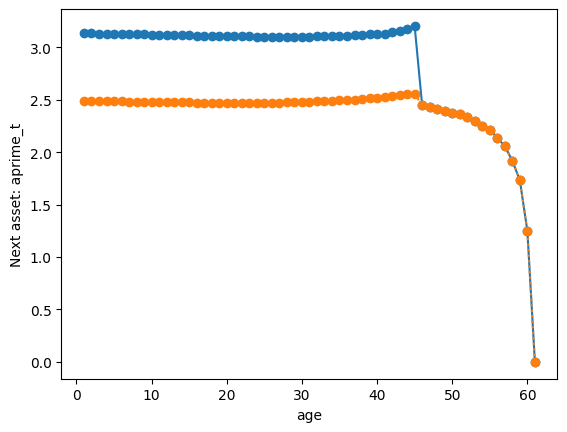

In [7]:

# 来期の資産の政策関数をプロット
# assetを固定する
df = pd.DataFrame({
    'x_axis': hp.h_grid,
    'y_axis': policy_fun_box[:,1,20]})
df2 = pd.DataFrame({
    'x_axis': hp.h_grid,
    'y_axis': policy_fun_box[:,0,20]})
# plot
plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')  # 最も生産性が高い場合（青色）
plt.plot('x_axis', 'y_axis', data=df2, linestyle=':', marker='o')  # 最も生産性が低い場合（オレンジ色）
plt.xlabel('age')
plt.ylabel('Next asset: aprime_t')
# plt.legend([""])
plt.show()

In [153]:

A_supply_h = np.zeros(hp.NJ)
for h in range(hp.NJ):       # 年齢
    for i_l in range(hp.Nl):     # スキル
        for i_a in range(hp.Na): # 今期資産インデックス
            mu = mu_dist_box[h, i_l, i_a]
            if mu == 0:
                continue
            aprime = policy_fun_box[h, i_l, i_a]  # 次期資産（実数値）
            A_supply_h[h] += aprime * mu

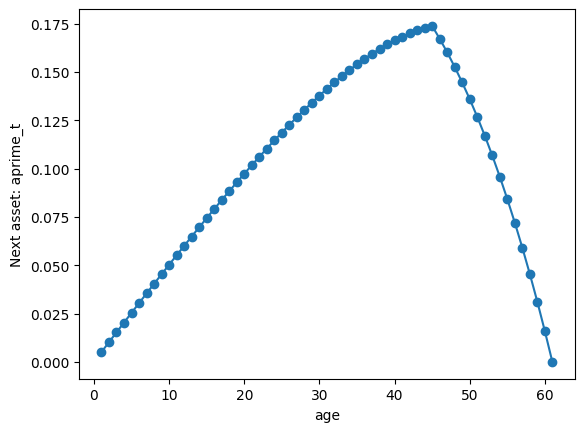

In [154]:
# 来期の資産の政策関数をプロット
# assetを固定する
df = pd.DataFrame({
    'x_axis': hp.h_grid,
    'y_axis': A_supply_h})

# plot
plt.plot('x_axis', 'y_axis', data=df, linestyle='-', marker='o')  # 最も生産性が高い場合（青色）

plt.xlabel('age')
plt.ylabel('Next asset: aprime_t')
# plt.legend([""])
plt.show()

### 資産分布

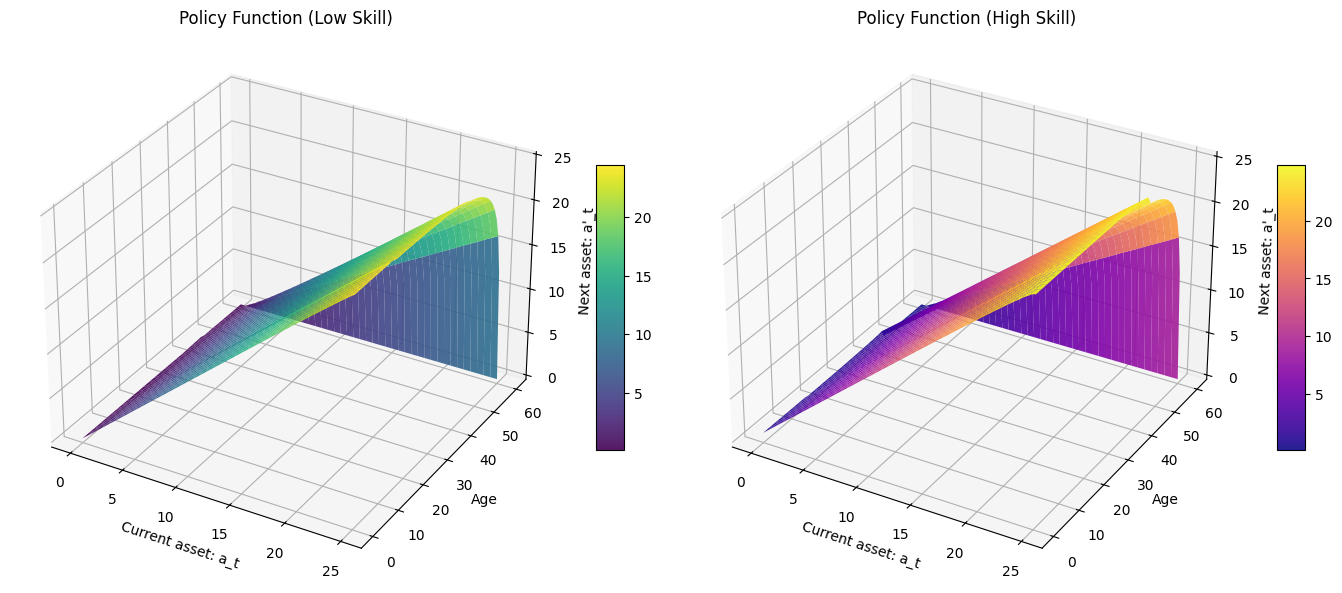

In [159]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# データ準備
a_grid = hp.a_grid
ages = np.arange(hp.NJ)
A, H = np.meshgrid(a_grid, ages)

Z_low = policy_fun_box[:, 0, :]   # shape: (age, asset) for low skill
Z_high = policy_fun_box[:, 1, :]  # shape: (age, asset) for high skill

fig = plt.figure(figsize=(14, 6))

# ---- Low Skill Plot ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(A, H, Z_low, cmap='viridis', alpha=0.9)
ax1.set_title('Policy Function (Low Skill)')
ax1.set_xlabel('Current asset: a_t')
ax1.set_ylabel('Age')
ax1.set_zlabel('Next asset: a\'_t')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# ---- High Skill Plot ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(A, H, Z_high, cmap='plasma', alpha=0.9)
ax2.set_title('Policy Function (High Skill)')
ax2.set_xlabel('Current asset: a_t')
ax2.set_ylabel('Age')
ax2.set_zlabel('Next asset: a\'_t')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


### 人口分布

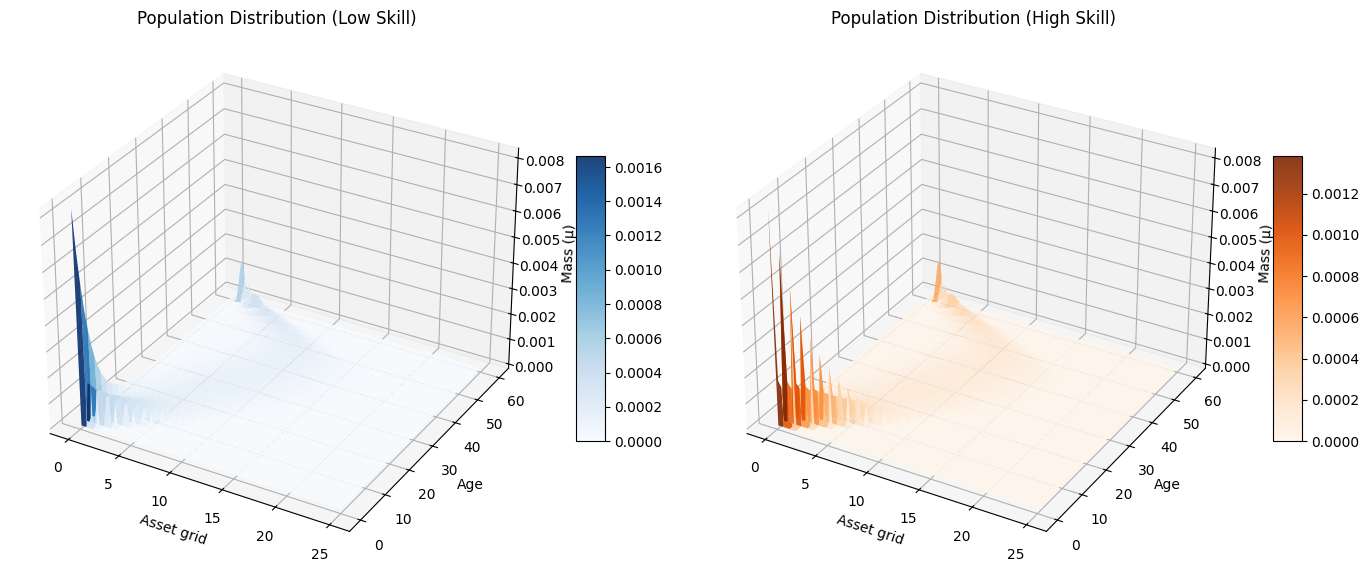

In [156]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# x: 資産グリッド, y: 年齢
a_grid = hp.a_grid
ages = np.arange(hp.NJ)
A, H = np.meshgrid(a_grid, ages)

# 人口分布（生産性 low / high）
Z_low = mu_dist_box[:, 0, :]   # shape: (age, asset) for low skill
Z_high = mu_dist_box[:, 1, :]  # shape: (age, asset) for high skill

fig = plt.figure(figsize=(14, 6))

# ---- Low Skill ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(A, H, Z_low, cmap='Blues', alpha=0.9)
ax1.set_title('Population Distribution (Low Skill)')
ax1.set_xlabel('Asset grid')
ax1.set_ylabel('Age')
ax1.set_zlabel('Mass (μ)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# ---- High Skill ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(A, H, Z_high, cmap='Oranges', alpha=0.9)
ax2.set_title('Population Distribution (High Skill)')
ax2.set_xlabel('Asset grid')
ax2.set_ylabel('Age')
ax2.set_zlabel('Mass (μ)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()
